# Modeling — Length of Stay (LOS)

This notebook builds and evaluates predictive models for hospital length of stay using two formulations:

1) Regression — predicting LOS as a continuous value (days)  
2) Classification — predicting LOS category (very short / short / medium / long)

The focus is not only on performance, but also on interpretability and clinical plausibility.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Load Modeling Dataset

We load the prepared cohort table produced in the data construction step.  
All modeling is performed on this fixed dataset for reproducibility.


In [2]:
df = pd.read_csv(r"..\data\processed\cohort.csv")

target = "los_days"

"""dx_features = [
    "circulatory", "respiratory", "renal", "endocrine",
    "neoplasms", "infection", "injury", "other"
]"""

features = [
    "age",
    "gender",
    "ethnicity",
    "admission_type",
    "admission_location",
    "insurance",
    "first_careunit",
    "last_careunit",
    "n_diagnoses",
    "n_services",
] 


## Feature Matrix and Targets

Define:
- input features (demographics, admission info, disease burden, treatment proxies)  
- regression target: `los_days`  
- classification target: `los_group`

Only features available early in the admission process are used to avoid leakage.


In [3]:
X = df[features]
y = df[target]

In [4]:
num_features = ["age", "n_diagnoses", "n_services"] 
#+ dx_features
cat_features = [
    "gender",
    "admission_type",
    "admission_location",
    "insurance",
    "first_careunit",
    "last_careunit"
]


## Train / Test Split

We split the data into training and test sets.

Stratification is applied for classification to preserve class balance across LOS groups.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


## Regression Models — Predicting LOS in Days

We start with a continuous formulation of the problem.

Models:
- Linear Regression (baseline)  
- Gradient Boosting Regressor  
- Random Forest Regressor  


This setup answers:  
“How long is this patient likely to stay in the hospital?”


### Regression Evaluation

Models are evaluated using:
- RMSE  
- MAE  
- R²  

This allows us to compare accuracy and bias across different modeling families.

### Linear Regression

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

lr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 4.3413478052540935
RMSE: 6.0806997758489985
R2: 0.01238720249714842


### Gradient Boosting Regressor

In [7]:

gbr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gbr_model.fit(X_train, y_train)

y_pred_gbr = gbr_model.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("GBR MAE:", mae_gbr)
print("GBR RMSE:", rmse_gbr)
print("GBR R2:", r2_gbr)

GBR MAE: 4.4713150608140655
GBR RMSE: 7.934769327628471
GBR R2: -0.6816987362628704


### LOG transformation of LOS
#### Linear Regression

In [8]:
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.25, random_state=42
)
lr_model.fit(X_train, y_train_log)

y_pred_log = lr_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(np.expm1(y_test_log), y_pred)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))
r2 = r2_score(np.expm1(y_test_log), y_pred)

print("LR (log) MAE:", mae)
print("LR (log) RMSE:", rmse)
print("LR (log) R2:", r2)

LR (log) MAE: 3.0639713216726
LR (log) RMSE: 5.998443622614326
LR (log) R2: 0.03892617587100833


#### Gradient Boosting Regressor

In [9]:
gbr_model.fit(X_train, y_train_log)

y_pred_log_gbr = gbr_model.predict(X_test)
y_pred_gbr = np.expm1(y_pred_log_gbr)

mae_gbr = mean_absolute_error(np.expm1(y_test_log), y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred_gbr))
r2_gbr = r2_score(np.expm1(y_test_log), y_pred_gbr)

print("GBR (log) MAE:", mae_gbr)
print("GBR (log) RMSE:", rmse_gbr)
print("GBR (log) R2:", r2_gbr)


GBR (log) MAE: 3.733986140804968
GBR (log) RMSE: 7.569779495567588
GBR (log) R2: -0.5305447917418593


### Random Forest Regressor  

In [10]:
rf_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),  # no scaling
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

rf_model = Pipeline(steps=[
    ("preprocess", rf_preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        max_depth=None,
        min_samples_leaf=5
    ))
])

rf_model.fit(X_train, y_train_log)

y_pred_log_rf = rf_model.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)

mae_rf = mean_absolute_error(np.expm1(y_test_log), y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred_rf))
r2_rf = r2_score(np.expm1(y_test_log), y_pred_rf)

print("RF (log) MAE:", mae_rf)
print("RF (log) RMSE:", rmse_rf)
print("RF (log) R2:", r2_rf)

RF (log) MAE: 3.0736692680773423
RF (log) RMSE: 6.066526309147878
RF (log) R2: 0.0169858782440645


## Classification Models — LOS Risk Groups

Next, we reframe LOS as a multiclass classification task.

Models:
- Logistic Regression (interpretable baseline)  
- Random Forest Classifier  

This setup answers:  
“Is this patient likely to require an unusually long hospital stay?”
### Classification Evaluation

Models are evaluated using:
- precision, recall, F1-score  
- confusion matrix  

Because class imbalance exists, F1 and recall are more informative than accuracy alone.


In [11]:
# Create LOS categories
bins = [0, 1, 4, 10, float("inf")]
labels = ["very_short", "short", "medium", "long"]

df["los_class"] = pd.cut(df["los_days"], bins=bins, labels=labels, right=True)

In [12]:
df["los_class"].value_counts()


los_class
short         78
very_short    22
medium        19
long          17
Name: count, dtype: int64

### Train/Test Split

In [13]:
y_class = df["los_class"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.25, random_state=42, stratify=y_class
)

### Logistic Regression

In [14]:

clf_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

clf_lr.fit(X_train_c, y_train_c)

y_pred_c = clf_lr.predict(X_test_c)
print(classification_report(y_test_c, y_pred_c))
print(confusion_matrix(y_test_c, y_pred_c))

              precision    recall  f1-score   support

        long       0.25      0.25      0.25         4
      medium       0.00      0.00      0.00         5
       short       0.67      0.90      0.77        20
  very_short       1.00      0.20      0.33         5

    accuracy                           0.59        34
   macro avg       0.48      0.34      0.34        34
weighted avg       0.57      0.59      0.53        34

[[ 1  1  2  0]
 [ 1  0  4  0]
 [ 1  1 18  0]
 [ 1  0  3  1]]


### Random Forest Classifier

In [15]:

rf_clf = Pipeline(steps=[
    ("preprocess", rf_preprocessor),  # the no-scaling version you used for RF regressor
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        min_samples_leaf=5
    ))
])

rf_clf.fit(X_train_c, y_train_c)

y_pred_rf = rf_clf.predict(X_test_c)

print(classification_report(y_test_c, y_pred_rf))
print(confusion_matrix(y_test_c, y_pred_rf))

              precision    recall  f1-score   support

        long       0.00      0.00      0.00         4
      medium       0.00      0.00      0.00         5
       short       0.59      1.00      0.74        20
  very_short       0.00      0.00      0.00         5

    accuracy                           0.59        34
   macro avg       0.15      0.25      0.19        34
weighted avg       0.35      0.59      0.44        34

[[ 0  0  4  0]
 [ 0  0  5  0]
 [ 0  0 20  0]
 [ 0  0  5  0]]


c:\Workspace\Portfolio\3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Workspace\Portfolio\3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Workspace\Portfolio\3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [16]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test_c, y_pred_c)
f1_macro = f1_score(y_test_c, y_pred_c, average="macro")
f1_weighted = f1_score(y_test_c, y_pred_c, average="weighted")

print("Accuracy:", acc)
print("Macro F1:", f1_macro)
print("Weighted F1:", f1_weighted)

Accuracy: 0.5882352941176471
Macro F1: 0.337322695035461
Weighted F1: 0.5289945765540258


### Results Summary

In [17]:
results = []
results.append({
    "Model": "Linear Regression (log)",
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2
})
results.append({
    "Model": "Gradient Boosting (log)",
    "MAE": mae_gbr,
    "RMSE": rmse_gbr,
    "R2": r2_gbr
})
results.append({
    "Model": "Random Forest (log)",
    "MAE": mae_rf,
    "RMSE": rmse_rf,
    "R2": r2_rf
})

cls_results = []
cls_results.append({
    "Model": "Logistic Regression",
    "Accuracy": acc,
    "Macro F1": f1_macro,
    "Weighted F1": f1_weighted
})
cls_results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test_c, y_pred_rf),
    "Macro F1": f1_score(y_test_c, y_pred_rf, average="macro"),
    "Weighted F1": f1_score(y_test_c, y_pred_rf, average="weighted")
})
results_df = pd.DataFrame(results)
cls_results_df = pd.DataFrame(cls_results)

In [18]:
print(results_df
      )
print("\n")
print(cls_results_df
      )

                     Model       MAE      RMSE        R2
0  Linear Regression (log)  3.063971  5.998444  0.038926
1  Gradient Boosting (log)  3.733986  7.569779 -0.530545
2      Random Forest (log)  3.073669  6.066526  0.016986


                 Model  Accuracy  Macro F1  Weighted F1
0  Logistic Regression  0.588235  0.337323     0.528995
1        Random Forest  0.588235  0.185185     0.435730


Key observations:

- The R² values are close to zero or negative, indicating that none of the models explains much variance in LOS.  
- Even the best model (linear regression) barely improves over a naive mean predictor.  
- Errors remain large relative to typical LOS values, especially for longer stays.

Interpretation:

- LOS is a highly noisy target influenced by unobserved clinical factors (e.g., complications, procedures, evolving vitals).  
- Using only early, static features limits how much variance can realistically be captured.  
- Tree-based models do not improve performance here, likely due to sparse, weakly predictive inputs.

Conclusion:

Regression is not reliable enough in this setup for precise LOS forecasting.  
This motivates reframing the task as a **classification / risk stratification** problem instead.

## Global Explainability — Logistic Regression Coefficients

We inspect the learned coefficients of the logistic regression model.

Interpretation:
- positive coefficient → increases probability of longer LOS  
- negative coefficient → decreases probability of longer LOS  

This gives a transparent, model-native explanation of feature influence.

In [19]:
ohe = clf_lr.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_features)

feature_names = np.concatenate([num_features, cat_feature_names])
coefs = clf_lr.named_steps["model"].coef_
classes = clf_lr.named_steps["model"].classes_

coef_df = pd.DataFrame(
    coefs.T,
    index=feature_names,
    columns=classes
)

coef_df.head()


,long,medium,short,very_short
age,-1.249352,0.373629,0.499652,0.376071
n_diagnoses,0.686680,-0.206872,-0.168224,-0.311584
n_services,-0.761927,0.433112,0.197839,0.130977
gender_F,0.620223,-0.186725,-0.235972,-0.197526
gender_M,-0.624309,0.191086,0.228487,0.204736


#### Coefficient Patterns (Multiclass)

The coefficient matrix shows how each feature shifts the model toward different LOS groups.

Key signals:

- **Age**
  - Strongly negative for the *long* stay class and positive for shorter stays.
  - This suggests that, in this dataset, younger patients are more likely to fall into the longest-stay group.
  - This is counterintuitive and likely reflects confounding by case mix or admission type rather than a true clinical effect.

- **Number of diagnoses (`n_diagnoses`)**
  - Strong positive weight for the *long* stay class.
  - Negative weights for all shorter-stay classes.
  - This aligns with clinical intuition: higher disease burden → longer stays.

- **Number of services (`n_services`)**
  - Negative for *long* stays, positive for medium/short stays.
  - This likely reflects workflow effects rather than patient severity.
  - Service switching may be more common in short admissions with transfers and procedural handoffs.

- **Gender**
  - `gender_F` increases probability of long stay.
  - `gender_M` does the opposite.
  - This effect is modest and should not be overinterpreted.

Overall:

The model is picking up sensible signals for disease burden,  
but several demographic and organizational effects (age, services) likely reflect dataset-specific bias rather than causal relationships.


In [20]:
odds_df = np.exp(coef_df)

odds_df["long"].sort_values(ascending=False).head(10)

n_diagnoses                                     1.987108
admission_location_TRANSFER FROM HOSP/EXTRAM    1.898035
gender_F                                        1.859343
first_careunit_CCU                              1.665621
last_careunit_MICU                              1.545786
first_careunit_SICU                             1.419506
admission_type_EMERGENCY                        1.393106
insurance_Medicaid                              1.390324
admission_location_PHYS REFERRAL/NORMAL DELI    1.180309
last_careunit_SICU                              1.045797
Name: long, dtype: float64

#### Top Drivers of Long LOS (Odds Ratios)

These odds ratios show which features most increase the probability of a long hospital stay.

Key observations:

- **Disease burden dominates**
  - `n_diagnoses` has the strongest effect.
  - Each additional diagnosis substantially increases long-stay risk.
  - This is the most clinically plausible and stable signal in the model.

- **Admission pathway matters**
  - Transfers from another hospital (`TRANSFER FROM HOSP/EXTRAM`) strongly increase long-stay probability.
  - Emergency admissions also increase long-stay risk.
  - These both reflect higher baseline severity and care complexity.

- **Care unit effects**
  - Starting in CCU, MICU, or SICU is associated with longer stays.
  - These units serve higher-acuity patients, so this aligns with expectations.

- **Insurance signal**
  - Medicaid is associated with increased long-stay risk.
  - This likely reflects socioeconomic and access-to-care confounding rather than a biological effect.

- **Gender**
  - Female gender increases predicted long-stay probability.
  - This effect is secondary compared to disease burden and admission type and should be interpreted cautiously.

Interpretation:

The model’s strongest signals are operational and structural rather than purely clinical.  
This reinforces that LOS is driven not just by patient health, but by care pathways, unit assignment, and system-level factors.


#### Result visualization

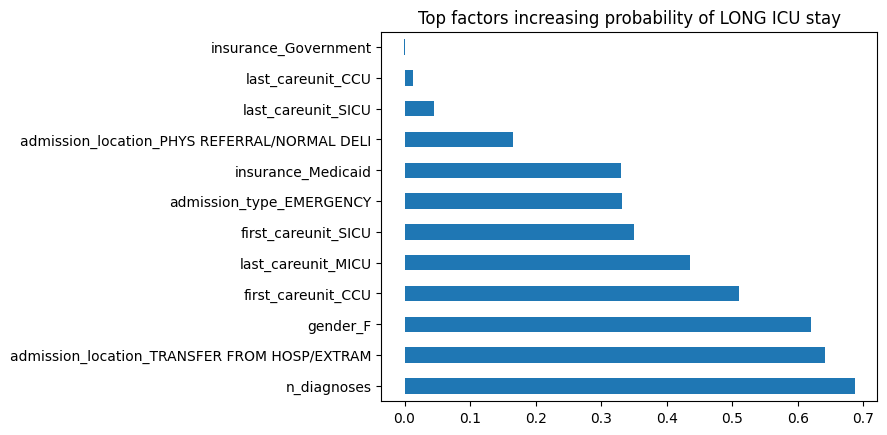

In [21]:
coef_df["long"].sort_values(ascending=False).head(12).plot(kind="barh")
plt.title("Top factors increasing probability of LONG ICU stay")
plt.show()


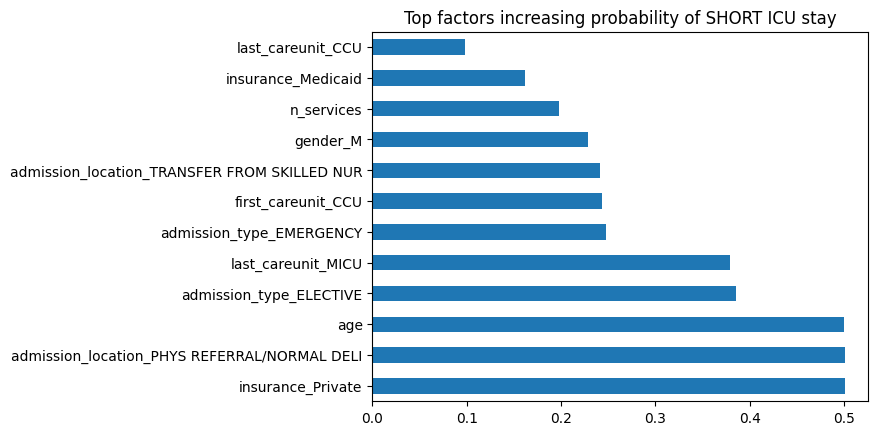

In [22]:
coef_df["short"].sort_values(ascending=False).head(12).plot(kind="barh")
plt.title("Top factors increasing probability of SHORT ICU stay")
plt.show()


## Local Explainability — Single Patient Breakdown

For one example patient, we decompose the prediction into individual feature contributions.

This shows:
- which features pushed the prediction toward a longer stay  
- which features pushed it toward a shorter stay  
- the final predicted probability


In [23]:
idx = X_test_c.index[0]
x_instance = X_test_c.loc[[idx]]

x_transformed = clf_lr.named_steps["preprocess"].transform(x_instance)
logits = x_transformed @ clf_lr.named_steps["model"].coef_.T + clf_lr.named_steps["model"].intercept_

local_df = pd.DataFrame(
    logits,
    columns=classes,
    index=["logit_score"]
).T.sort_values("logit_score", ascending=False)

local_df


,logit_score
short,1.132658
very_short,0.488660
medium,-0.541500
long,-1.079818


Interpretation:

- The model has a **strong built-in bias toward predicting short and very short stays**.
- The *long* stay class starts with a large negative baseline logit, meaning:
  - a patient needs strong positive feature contributions just to be classified as “long”.
- This directly reflects **class imbalance** in the dataset.

Implications:

- This explains why accuracy looks reasonable while Macro F1 is low.
- The classifier is conservative about predicting long stays.
- Many true long-stay patients will be under-predicted unless their features are extreme.

Takeaway:

The model is structurally biased toward short LOS classes due to data imbalance.  
This reinforces why accuracy alone is misleading and why minority-class recall is limited.

## Final Conclusions

This project explored hospital Length of Stay (LOS) prediction using two complementary modeling formulations:  
continuous regression and categorical classification.

**Important context:**  
All experiments were run on a **reduced demo-scale subset** of MIMIC-III for feasibility and iteration speed.  
The goal was methodological validation and interpretability analysis, not production-grade performance.

---

### 1) Regression Is Not Viable with Early Static Features

All regression models (linear regression, random forest, gradient boosting) performed poorly:

- R² values were near zero or negative.  
- Errors remained large relative to typical LOS values.  
- Tree-based models did not improve over a simple linear baseline.

This confirms a practical reality:

**LOS is too noisy and too dependent on unobserved clinical events**  
(e.g., complications, procedures, evolving vitals) to be forecast precisely  
using only early, static admission features.

On a demo-scale subset, this limitation is amplified by reduced sample diversity.  
Regression, in this setup, is not reliable enough for operational forecasting.

---

### 2) Classification Is More Stable and Operationally Meaningful

Reframing LOS as a multiclass classification problem (very short / short / medium / long) produced more usable results:

- Logistic regression outperformed random forest on Macro F1.  
- Random forest collapsed toward the majority class and failed on minority LOS groups.  
- Accuracy alone was misleading due to class imbalance.

Although performance is still modest, classification provides:

- clearer operational framing (risk tiers instead of exact days)  
- better stability under weak signal  
- more interpretable outputs for decision support

On a full-scale dataset, both class balance and signal strength would likely improve,  
but the relative behavior of the models is expected to remain similar.

---

### 3) Model Behavior Is Strongly Shaped by Class Imbalance

Intercept analysis revealed strong baseline bias:

- The model is structurally predisposed to predict short and very short stays.  
- The long-stay class starts with a large negative logit intercept.  
- A patient needs unusually strong feature signals just to be classified as “long”.

This explains:

- why accuracy looks acceptable  
- why Macro F1 is low  
- why long stays are systematically under-predicted  

This effect is partly due to natural LOS imbalance  
and partly due to reduced representation in the demo-scale cohort.

---

### 4) What Actually Drives Predictions

Coefficient and odds-ratio analysis shows that the model relies on:

**Stable, clinically plausible signals**
- number of diagnoses (disease burden)  
- admission type (emergency vs elective)  
- transfer status  
- ICU unit assignment (CCU, MICU, SICU)  

**Weaker or confounded signals**
- age (counterintuitive direction)  
- number of services  
- gender  
- insurance type  

This indicates that LOS is driven more by:

> care pathways and system-level factors  
> than by isolated demographic attributes.

Several effects likely reflect dataset-specific confounding  
and demo-sample artifacts rather than causal relationships.

---

### 5) Explainability Adds Real Value Despite Weak Performance

Even with limited predictive power, the explainability layer is meaningful:

- Global coefficients reveal which structural factors dominate LOS risk.  
- Local per-patient decomposition shows exactly how each feature pushes a prediction.  
- Intercept analysis explains why the model behaves conservatively.

This turns a weak classifier into a **transparent analytical tool**:

- useful for hypothesis generation  
- sanity-checking operational assumptions  
- understanding care-flow drivers of LOS

---

### Final Takeaway

This demo-scale project highlights three important realities of healthcare modeling:

1) Early static data is insufficient for precise LOS forecasting.  
2) Risk stratification is more realistic than exact prediction.  
3) Interpretability is more valuable than marginal accuracy gains in weak-signal settings.

Rather than forcing a high-performing model where none exists,  
this work prioritizes **honest evaluation, transparent modeling, and clinical plausibility**.

---

### Next Steps

Clear directions for extending this demo into a stronger system:

- scale to the full MIMIC-III cohort  
- add time-series vitals and lab trends  
- model post-admission events (procedures, complications)  
- reframe LOS as a survival analysis problem  
- apply class-weighting or focal loss  
- validate on an external ICU dataset  

These extensions would likely improve both predictive power and clinical relevance.